In [67]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from math import*
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import math


In [68]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [69]:
d=100
L=2
r=1

In [85]:
def cosine_similarity(u, v):
    u_flat = u.flatten()
    v_flat = v.flatten()
    return torch.dot(u_flat, v_flat) / (u_flat.norm() * v_flat.norm())


In [70]:
class DeepMultiHeadAttention(nn.Module):
    def __init__(self, d=100, r=1, num_heads=5, num_layers=2):
        super().__init__()
        self.d = d
        self.r = r
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.Q = nn.ParameterList()

        for _ in range(num_layers * num_heads):
            init = torch.randn(d, r)  # Initialisation aléatoire comme dans l'ancien code
            self.Q.append(nn.Parameter(init))

    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        sftm = nn.Softmax(dim=-1)

        for layer in range(self.num_layers):
            attn_outputs = []
            for head in range(self.num_heads):
                idx = layer * self.num_heads + head
                Q_proj = self.Q[idx]  # (d, r)
                xQ = torch.einsum("imk,kr->imr", x, Q_proj) / math.sqrt(self.d)  # (batch, seq_len, r)
                #print("xQ : ", xQ.shape)
                scores = torch.einsum("imr,inr->imn", xQ, xQ)    # (batch, seq_len, seq_len)
                #print("scores : ", scores.shape)
                Att = sftm(scores)
                attn_output = torch.einsum("imn,ink->imk", Att, x)  # (batch, seq_len, d)
                attn_outputs.append(attn_output)
                #print("attn_output : ", attn_output.shape)

            # Moyenne des têtes
            x_new = sum(attn_outputs) / self.num_heads

            # Skip connection sauf pour la dernière couche
            if layer < self.num_layers - 1:
                x = x + x_new
            else:
                x = x_new

        return x

In [71]:
teacher = DeepMultiHeadAttention(
    d=d,
    r=1, 
    num_heads=5, 
    num_layers=2
).to(device)

# Figer ses poids pour en faire un vrai teacher
for param in teacher.parameters():
    param.requires_grad = False


In [72]:

def get_y(n):
    x = torch.randn((n, L, d)).to(device)  # séquence de longueur 2, dimension 500

    with torch.no_grad():
        y = teacher(x)  # passe dans le modèle enseignant

    return x, y



In [73]:

class generate_data(Dataset):
  def __init__(self,n):
    self.X,self.Y=get_y(n)
    self.samples=n


  def __getitem__(self,idx):
    return self.X[idx].to(device),self.Y[idx].to(device)

  def __len__(self):
    return self.samples


In [74]:
def quadloss(ypred, y):
    return torch.sum((ypred-y)**2)/d

In [123]:

def train(train_data, X_test,y_test,tol=1e-5,verbose=False,tied=False,wd=0.07/d, seed=42, n_passes=1):
    Att= DeepMultiHeadAttention(
        d=d,
        r=1,
        num_heads=5,
        num_layers=2
    ).to(device)

    optimizer = torch.optim.Adam(Att.parameters(), lr=0.01, weight_decay=wd)

    gen_Loss_list=[]
    cosine_log = [[] for _ in range(len(Att.Q))]  # une liste par tête



    epochs = 1500


    for t in range(epochs):
        train_loader = DataLoader(train_data, batch_size=300, shuffle=True)

        if t%(epochs/10)==0: print(t)
        for x,y in train_loader:



          for j in range(n_passes):
            y_pred = Att(x)
            loss = quadloss(y_pred,y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()



          gen_Loss_list.append(float(torch.mean((y_test-Att(X_test))**2)))
          for i, (q_student, q_teacher) in enumerate(zip(Att.Q, teacher.Q)):
              sim = cosine_similarity(q_student.data, q_teacher.data).item()
              cosine_log[i].append(sim)


    return gen_Loss_list, cosine_log

In [97]:

def get_errors(alpha,N_iter=1):
    global theta
    n=int(d*alpha)



    print("############################################")
    X_test,y_test=get_y(2000)
    train_data =generate_data(n)
    

    loss, cosine_log=train(train_data,X_test,y_test, seed=42)




    return loss, cosine_log

In [ ]:
alpha=15
alphas=[alpha]

test_loss, cosine_log = get_errors(alpha)

# save the results

np.save("results/alpha_{}_test_loss.npy".format(alpha), test_loss)
np.save("results/alpha_{}_cosine_log.npy".format(alpha), cosine_log)




############################################
0
150


No handles with labels found to put in legend.


7500
7500
(7500,)
0
1
2
3
4
5
6
7
8
9


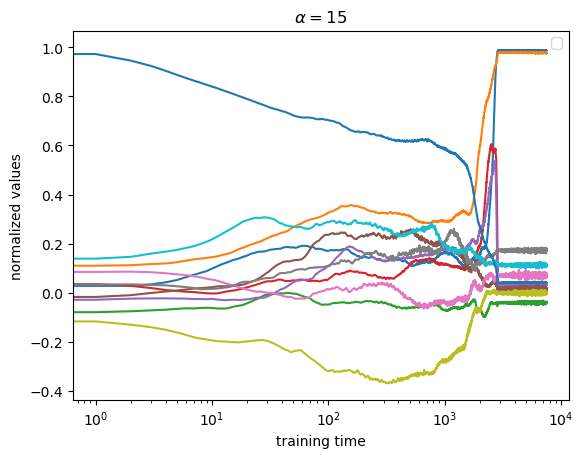

In [124]:

Loss = np.load("results/alpha_{}_test_loss.npy".format(alpha))
cosine_log = np.load("results/alpha_{}_cosine_log.npy".format(alpha))
print(len(test_loss))
print(len(cosine_log[0]))

print(Loss.shape)

# normalize the loss 
normalized_loss = Loss/np.max(Loss)



plt.xlabel("training time"); plt.ylabel("normalized values");plt.legend();plt.xscale("log");plt.title(r"$\alpha={}$".format(alpha))#;plt.show()


for i in range(len(cosine_log)):
    print(i)
    plt.plot(cosine_log[i], label="cosine similarity head {}".format(i+1))
plt.plot(normalized_loss, label="normalized loss")


plt.show()


In [86]:
for i, (Q_t, Q_s) in enumerate(zip(teacher.Q, student.Q)):
    sim = cosine_similarity(Q_t.data, Q_s.data)
    print(f"Tête {i} : cos_sim = {sim.item():.4f}")


NameError: name 'student' is not defined

In [ ]:
np.save("C1_informed0.npy",C1)
np.save("C2_informed0.npy",C2)

In [ ]:

fig, ax = plt.subplots(1,3, figsize=(12,3))
ax=ax.flatten()
ax[0].errorbar(alphas, Eg.mean(1),yerr=Eg.std(1), label=r"$\epsilon_g$")
ax[0].legend()




ax[1].errorbar(alphas, Q.mean(1),yerr=Q.std(1), label=r"$q_1$")




ax[1].legend()


ax[2].errorbar(alphas, Loss.mean(1),yerr=Loss.std(1), label=r"$Loss$")
ax[2].legend()

for axx in ax:
  axx.set_xlabel(r"$\alpha$")



In [ ]:
np.save("alphas.npy", alphas)

In [ ]:
np.save("Eg_inf.npy", Eg)
np.save("Q_inf.npy", alphas)
np.save("Loss_inf.npy", Loss)

In [ ]:


def train(train_loader, X_test,y_test,tol=1e-5,verbose=False,tied=False,wd=0.07/d, seed=42, n_passes=3):
    Att=Attention(d,r,seed).to(device)

    optimizer = torch.optim.SGD([{'params': [Att.Q1,Att.Q2],"weight_decay":wd}],lr=15)

    gen_Loss_list=[]
    Loss_list=[]
    Q1_list=[]
    M1_list=[]
    Q2_list=[]
    M2_list=[]


    for t in range(1700):

        if t%500==0: print(t)
        for x,y in train_loader:



          for j in range(n_passes):
            y_pred = Att(x)
            loss = quadloss(y_pred,y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

          Loss_list.append(loss.item()+wd/2*float(torch.sum(Att.Q1.cpu().flatten()**2)))
          M1_list.append(float(Att.Q1.cpu().flatten()@w1.flatten()/d))
          Q1_list.append(float(Att.Q1.cpu().flatten()@Att.Q1.cpu().flatten()/d))
          M2_list.append(float(Att.Q2.cpu().flatten()@w2.flatten()/d))
          Q2_list.append(float(Att.Q2.cpu().flatten()@Att.Q2.cpu().flatten()/d))


        if t%20==0 and t>0 :

            gen_Loss_list.append(float(torch.mean((y_test-Att(X_test))**2)))

    Q1=Att.Q1.cpu().flatten()
    Q2=Att.Q2.cpu().flatten()







    m1=Q1@w1.flatten()/d
    q1=Q1@Q1/d
    m2=Q2@w2.flatten()/d
    q2=Q2@Q2/d
    print(q1)


    plt.plot(np.abs(np.array(M1_list)/np.array(Q1_list)**.5),  alpha=0.8, label="layer 1")
    plt.plot(np.abs(np.array(M2_list)/np.array(Q2_list)**.5),  alpha=0.3, label="layer 2")
    plt.xlabel("training time"); plt.ylabel("cosine similarity");plt.legend();plt.xscale("log");plt.title(r"$\alpha={}$".format(alpha));plt.show()
    plt.plot(Loss_list, c="b", alpha=0.3); plt.show()




    return np.mean(gen_Loss_list[-5:]),m1.detach().numpy(),q1.detach().numpy(),m2.detach().numpy(),q2.detach().numpy(),np.mean(Loss_list[-1:])